In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Magda\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
df = pd.read_csv('../agent/cleaned_data/AAON.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,9.506667,9.600000,9.337778,9.453333,8.950765,501000
1,1/3/2013,9.444445,9.746667,9.382222,9.617778,9.106468,344700
2,1/4/2013,9.662222,9.697778,9.546667,9.666667,9.152760,141300
3,1/7/2013,9.604445,9.688889,9.537778,9.560000,9.051764,132000
4,1/8/2013,9.577778,9.640000,9.422222,9.582222,9.072803,103200


In [3]:
class Agent:

    LEARNING_RATE = 1e-4
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money):
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        state = self.get_state(0)
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and initial_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, close[t], invest, initial_money)
                )
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest
        
    
    def train(self, iterations, checkpoint, initial_money):
        for i in range(iterations):
            ep_history = []
            total_profit = 0
            inventory = []
            state = self.get_state(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3, cost: %f, total money: %f'%(i + 1, total_profit, cost,
                                                                                  starting_money))

In [4]:
close = df.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = close,
             skip = skip)
agent.train(iterations = 200, checkpoint = 10, initial_money = initial_money)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


C:\Users\Magda\anaconda3\lib\site-packages\ipykernel_launcher.py:107: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


epoch: 10, total rewards: 67.174474.3, cost: -32970.265625, total money: 10067.174474
epoch: 20, total rewards: 124.256685.3, cost: -33376.101562, total money: 10124.256685
epoch: 30, total rewards: 162.796684.3, cost: -33645.269531, total money: 10162.796684
epoch: 40, total rewards: 231.682246.3, cost: -33825.234375, total money: 10231.682246
epoch: 50, total rewards: 314.916675.3, cost: -33979.937500, total money: 10314.916675
epoch: 60, total rewards: 382.978884.3, cost: -34147.644531, total money: 10382.978884
epoch: 70, total rewards: 611.307760.3, cost: -34482.562500, total money: 10561.887762
epoch: 80, total rewards: 638.918867.3, cost: -34579.835938, total money: 10490.828871
epoch: 90, total rewards: 919.874419.3, cost: -34310.878906, total money: 10522.634425
epoch: 100, total rewards: 1029.493301.3, cost: -34070.660156, total money: 10212.103306
epoch: 110, total rewards: 828.877751.3, cost: -34493.027344, total money: 10432.057755
epoch: 120, total rewards: 909.677740.3, 

In [5]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

day 0: buy 1 unit at price 9.453333, total balance 9990.546667
day 1: buy 1 unit at price 9.617778, total balance 9980.928889
day 2: buy 1 unit at price 9.666667, total balance 9971.262222
day 3: buy 1 unit at price 9.560000, total balance 9961.702222
day 4: buy 1 unit at price 9.582222, total balance 9952.120000
day 5: buy 1 unit at price 9.653334, total balance 9942.466666
day 6: buy 1 unit at price 9.786667, total balance 9932.679999
day 7: buy 1 unit at price 9.871111, total balance 9922.808888
day 8, sell 1 unit at price 10.053333, investment 6.346972 %, total balance 9932.862222,
day 9: buy 1 unit at price 9.915556, total balance 9922.946666
day 10, sell 1 unit at price 9.751111, investment 1.386320 %, total balance 9932.697777,
day 11, sell 1 unit at price 9.880000, investment 2.206894 %, total balance 9942.577777,
day 12: buy 1 unit at price 10.013333, total balance 9932.564444
day 13: buy 1 unit at price 10.120000, total balance 9922.444444
day 14: buy 1 unit at price 9.982223

day 278, sell 1 unit at price 18.320000, investment -13.476075 %, total balance 9890.664449,
day 280: buy 1 unit at price 18.786667, total balance 9871.877782
day 281, sell 1 unit at price 18.773333, investment -10.375561 %, total balance 9890.651114,
day 282: buy 1 unit at price 19.233334, total balance 9871.417781
day 283: buy 1 unit at price 19.606667, total balance 9851.811114
day 285: buy 1 unit at price 19.693333, total balance 9832.117782
day 289: buy 1 unit at price 19.366667, total balance 9812.751115
day 292: buy 1 unit at price 19.366667, total balance 9793.384448
day 293: buy 1 unit at price 20.506666, total balance 9772.877782
day 294, sell 1 unit at price 20.500000, investment -0.581963 %, total balance 9793.377782,
day 295: buy 1 unit at price 20.459999, total balance 9772.917783
day 298: buy 1 unit at price 19.453333, total balance 9753.464450
day 300, sell 1 unit at price 18.246666, investment -15.524696 %, total balance 9771.711116,
day 301, sell 1 unit at price 18.44

day 461: buy 1 unit at price 19.440001, total balance 9790.204448
day 463, sell 1 unit at price 20.129999, investment 6.507934 %, total balance 9810.334447,
day 466, sell 1 unit at price 20.870001, investment 12.204303 %, total balance 9831.204448,
day 469, sell 1 unit at price 21.129999, investment 11.858125 %, total balance 9852.334447,
day 471, sell 1 unit at price 21.120001, investment 16.556291 %, total balance 9873.454448,
day 472: buy 1 unit at price 20.959999, total balance 9852.494449
day 473: buy 1 unit at price 20.469999, total balance 9832.024449
day 475, sell 1 unit at price 20.059999, investment 8.373848 %, total balance 9852.084449,
day 476: buy 1 unit at price 20.450001, total balance 9831.634448
day 478: buy 1 unit at price 21.190001, total balance 9810.444448
day 479, sell 1 unit at price 21.120001, investment 18.452052 %, total balance 9831.564448,
day 480: buy 1 unit at price 21.150000, total balance 9810.414449
day 481: buy 1 unit at price 20.719999, total balance 

day 626, sell 1 unit at price 22.389999, investment -6.591573 %, total balance 9729.044433,
day 627, sell 1 unit at price 22.520000, investment -7.018988 %, total balance 9751.564433,
day 628, sell 1 unit at price 22.850000, investment -4.152684 %, total balance 9774.414433,
day 629, sell 1 unit at price 22.750000, investment -0.087837 %, total balance 9797.164433,
day 631, sell 1 unit at price 22.620001, investment -2.500000 %, total balance 9819.784434,
day 632: buy 1 unit at price 22.110001, total balance 9797.674434
day 633: buy 1 unit at price 22.240000, total balance 9775.434434
day 634, sell 1 unit at price 22.629999, investment -4.191370 %, total balance 9798.064433,
day 635: buy 1 unit at price 23.180000, total balance 9774.884433
day 636: buy 1 unit at price 22.940001, total balance 9751.944432
day 638: buy 1 unit at price 22.530001, total balance 9729.414432
day 639: buy 1 unit at price 22.910000, total balance 9706.504432
day 640: buy 1 unit at price 23.020000, total balanc

day 771: buy 1 unit at price 20.920000, total balance 9403.134440
day 772, sell 1 unit at price 20.440001, investment 2.046929 %, total balance 9423.574441,
day 773, sell 1 unit at price 20.440001, investment -2.200953 %, total balance 9444.014442,
day 774: buy 1 unit at price 21.530001, total balance 9422.484441
day 775, sell 1 unit at price 21.190001, investment 2.615017 %, total balance 9443.674441,
day 777, sell 1 unit at price 21.040001, investment -0.941614 %, total balance 9464.714442,
day 778, sell 1 unit at price 20.940001, investment 2.346048 %, total balance 9485.654443,
day 780, sell 1 unit at price 20.469999, investment -4.790701 %, total balance 9506.124442,
day 783: buy 1 unit at price 20.459999, total balance 9485.664443
day 785: buy 1 unit at price 20.940001, total balance 9464.724443
day 786: buy 1 unit at price 20.959999, total balance 9443.764443
day 787: buy 1 unit at price 20.850000, total balance 9422.914443
day 788, sell 1 unit at price 20.969999, investment 0.8

day 945, sell 1 unit at price 29.170000, investment 7.045872 %, total balance 9113.594451,
day 948, sell 1 unit at price 30.730000, investment 13.604438 %, total balance 9144.324451,
day 951, sell 1 unit at price 29.500000, investment 11.320755 %, total balance 9173.824451,
day 952: buy 1 unit at price 29.600000, total balance 9144.224450
day 953: buy 1 unit at price 29.299999, total balance 9114.924451
day 956: buy 1 unit at price 29.200001, total balance 9085.724450
day 957: buy 1 unit at price 28.850000, total balance 9056.874450
day 958: buy 1 unit at price 28.900000, total balance 9027.974450
day 960, sell 1 unit at price 29.799999, investment 16.179336 %, total balance 9057.774449,
day 961: buy 1 unit at price 29.549999, total balance 9028.224450
day 962: buy 1 unit at price 29.150000, total balance 8999.074451
day 963: buy 1 unit at price 29.500000, total balance 8969.574451
day 964, sell 1 unit at price 29.450001, investment 5.253757 %, total balance 8999.024451,
day 965: buy 1

day 1110, sell 1 unit at price 36.169998, investment 11.635792 %, total balance 9364.574441,
day 1111: buy 1 unit at price 36.750000, total balance 9327.824441
day 1112: buy 1 unit at price 37.299999, total balance 9290.524442
day 1113: buy 1 unit at price 36.900002, total balance 9253.624440
day 1115, sell 1 unit at price 36.099998, investment 9.893456 %, total balance 9289.724439,
day 1116, sell 1 unit at price 36.750000, investment 11.702122 %, total balance 9326.474439,
day 1117: buy 1 unit at price 37.549999, total balance 9288.924439
day 1118, sell 1 unit at price 37.299999, investment 14.067273 %, total balance 9326.224439,
day 1119, sell 1 unit at price 37.950001, investment 15.525122 %, total balance 9364.174439,
day 1120: buy 1 unit at price 38.099998, total balance 9326.074441
day 1121: buy 1 unit at price 37.650002, total balance 9288.424439
day 1128: buy 1 unit at price 36.049999, total balance 9252.374440
day 1129: buy 1 unit at price 35.650002, total balance 9216.724439


day 1284, sell 1 unit at price 33.750000, investment -2.456643 %, total balance 10055.504449,
day 1286, sell 1 unit at price 33.200001, investment -4.871062 %, total balance 10088.704450,
day 1287: buy 1 unit at price 33.650002, total balance 10055.054448
day 1289, sell 1 unit at price 34.349998, investment -1.293106 %, total balance 10089.404447,
day 1290, sell 1 unit at price 34.599998, investment -0.288191 %, total balance 10124.004445,
day 1295: buy 1 unit at price 35.400002, total balance 10088.604444
day 1296: buy 1 unit at price 35.750000, total balance 10052.854444
day 1297: buy 1 unit at price 38.650002, total balance 10014.204442
day 1299, sell 1 unit at price 35.450001, investment 3.352774 %, total balance 10049.654443,
day 1300: buy 1 unit at price 35.400002, total balance 10014.254441
day 1301: buy 1 unit at price 35.400002, total balance 9978.854440
day 1302, sell 1 unit at price 35.950001, investment 6.047195 %, total balance 10014.804440,
day 1303, sell 1 unit at price 

day 1449: buy 1 unit at price 35.860001, total balance 10267.564446
day 1453: buy 1 unit at price 34.000000, total balance 10233.564446
day 1454, sell 1 unit at price 33.000000, investment -18.316835 %, total balance 10266.564446,
day 1456, sell 1 unit at price 31.889999, investment -18.751594 %, total balance 10298.454446,
day 1457: buy 1 unit at price 32.250000, total balance 10266.204446
day 1458, sell 1 unit at price 32.779999, investment -18.050003 %, total balance 10298.984445,
day 1459: buy 1 unit at price 32.660000, total balance 10266.324445
day 1460: buy 1 unit at price 32.189999, total balance 10234.134446
day 1461: buy 1 unit at price 32.209999, total balance 10201.924447
day 1463: buy 1 unit at price 32.369999, total balance 10169.554448
day 1464: buy 1 unit at price 32.490002, total balance 10137.064446
day 1465, sell 1 unit at price 33.500000, investment -16.040103 %, total balance 10170.564446,
day 1466: buy 1 unit at price 33.099998, total balance 10137.464448
day 1468

day 1625: buy 1 unit at price 48.590000, total balance 10338.004453
day 1626, sell 1 unit at price 48.270000, investment 1.407567 %, total balance 10386.274453,
day 1627: buy 1 unit at price 49.400002, total balance 10336.874452
day 1629: buy 1 unit at price 48.490002, total balance 10288.384450
day 1630: buy 1 unit at price 47.740002, total balance 10240.644448
day 1631, sell 1 unit at price 48.480000, investment 1.443814 %, total balance 10289.124448,
day 1632: buy 1 unit at price 49.520000, total balance 10239.604447
day 1633: buy 1 unit at price 50.180000, total balance 10189.424447
day 1634, sell 1 unit at price 49.730000, investment 2.114987 %, total balance 10239.154447,
day 1635, sell 1 unit at price 50.119999, investment -0.179247 %, total balance 10289.274445,
day 1636: buy 1 unit at price 49.270000, total balance 10240.004445
day 1637: buy 1 unit at price 49.709999, total balance 10190.294446
day 1638: buy 1 unit at price 49.980000, total balance 10140.314446
day 1639: buy 1

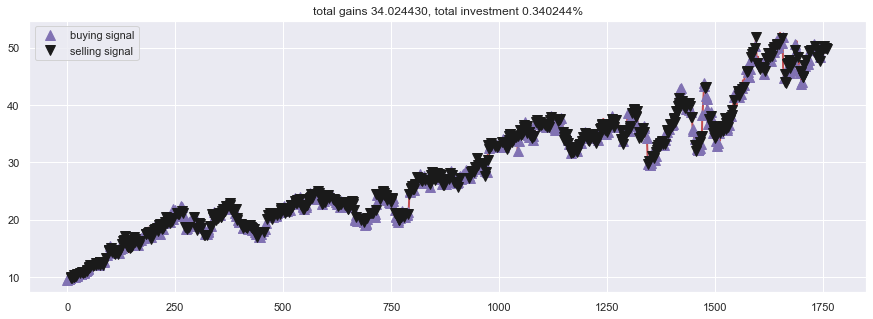

In [6]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()